# Week 6 Report

In [104]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

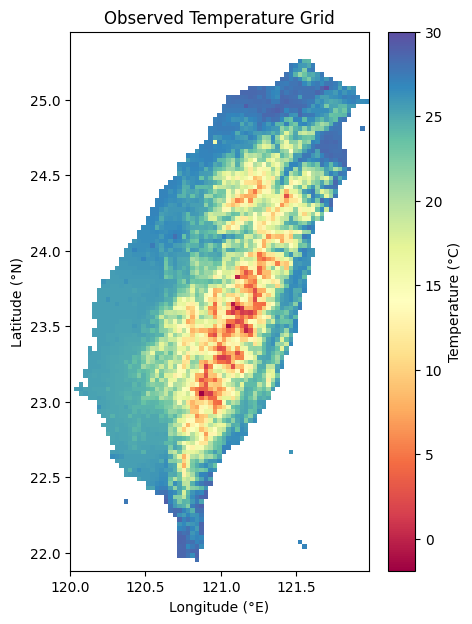

In [105]:
# Load temperature observations from XML
xml_path = os.path.join(os.getcwd(), "O-A0038-003.xml")
with open(xml_path, "r") as f:
    xml_content = f.read()

content = xml_content[xml_content.index("<Content>") + len("<Content>") : xml_content.index("</Content>")]
rows = [line.split(',') for line in content.split('\n') if line.strip()]

lon_count = 67
lat_count = 120

temperatures = []
loc_tem = []
for i in range(lat_count):
    for j in range(lon_count):
        value = float(rows[i][j])
        temperatures.append(value)
        loc_tem.append((j, i, value))

temp_grid = np.array(rows, dtype=float)
temp_grid[temp_grid == -999] = np.nan

lon_min, lat_min = 120.00, 21.88
lon_res = lat_res = 0.03
lon_max = lon_min + lon_res * (lon_count - 1)
lat_max = lat_min + lat_res * (lat_count - 1)
extent = [lon_min, lon_max, lat_min, lat_max]

plt.figure(figsize=(5, 7))
plt.imshow(temp_grid, cmap="Spectral", origin="lower", extent=extent)
plt.colorbar(label="Temperature (°C)")
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.title("Observed Temperature Grid")
plt.show()

## Preparing classification and regression datasets

- **Classification task**: predict whether an observation is valid (`label = 1`) or missing (`label = 0`) based on its longitude/latitude indices.
- **Regression task**: fit valid temperatures only, using coordinates as features.

In [106]:
cls_features, cls_labels = [], []
reg_features, reg_targets = [], []

for lon_idx, lat_idx, temp in loc_tem:
    cls_features.append([lon_idx, lat_idx])
    cls_labels.append(0 if temp == -999 else 1)
    if temp != -999:
        reg_features.append([lon_idx, lat_idx])
        reg_targets.append(temp)

X_cls = np.array(cls_features, dtype=np.float32)
y_cls = np.array(cls_labels, dtype=np.int64)
X_reg = np.array(reg_features, dtype=np.float32)
y_reg = np.array(reg_targets, dtype=np.float32)

print(f"Classification dataset: X={X_cls.shape}, y distribution={dict(zip(*np.unique(y_cls, return_counts=True)))}")
print(f"Regression dataset: X={X_reg.shape}, y range=({y_reg.min():.2f}, {y_reg.max():.2f}))")

Classification dataset: X=(8040, 2), y distribution={np.int64(0): np.int64(4545), np.int64(1): np.int64(3495)}
Regression dataset: X=(3495, 2), y range=(-1.90, 30.00))


### Discriminant Classifier Deliverables (Updated for QDA)

**(a) Implementation**  
Custom code (`train_gda` now performing QDA; `_log_gaussian`; `gda_scores`; `gda_predict`; `gda_predict_proba`) estimates priors, means, and per-class covariance matrices, then forms log odds = log p1 − log p0. No external classification library is used.

Parameter estimates:
$$
\hat\pi_k = \frac{m_k}{m}, \qquad \hat\mu_k = \frac{1}{m_k}\sum_{i:y_i=k} x_i, \qquad \hat\Sigma_k = \frac{1}{m_k}\sum_{i:y_i=k} (x_i-\hat\mu_k)(x_i-\hat\mu_k)^T, \; k\in\{0,1\}.
$$

**(b) Rationale (with explicit quadratic decision boundary)**  
Linear GDA assumes $\Sigma_0 = \Sigma_1$ producing a linear boundary. QDA relaxes this by allowing distinct $\Sigma_0, \Sigma_1$. The posterior log-odds is
$$
\log\frac{P(y=1\mid x)}{P(y=0\mid x)} = \log\frac{\pi_1}{\pi_0} - \tfrac{1}{2}\Big[(x-\mu_1)^T\Sigma_1^{-1}(x-\mu_1) - (x-\mu_0)^T\Sigma_0^{-1}(x-\mu_0)\Big] - \tfrac{1}{2}\Big(\log|\Sigma_1| - \log|\Sigma_0|\Big).
$$
Expanding and grouping terms in powers of \(x\) yields the quadratic decision surface (set log-odds = 0):
$$
-\tfrac{1}{2} x^T (\Sigma_1^{-1} - \Sigma_0^{-1}) x + (\mu_1^T\Sigma_1^{-1} - \mu_0^T\Sigma_0^{-1}) x - \tfrac{1}{2}(\mu_1^T\Sigma_1^{-1}\mu_1 - \mu_0^T\Sigma_0^{-1}\mu_0) - \tfrac{1}{2}\ln\frac{|\Sigma_1|}{|\Sigma_0|} + \ln\frac{\pi_1}{\pi_0} = 0.
$$
(If you swap class indices the signs adjust accordingly; the user-supplied form $-\tfrac{1}{2}x^T(\Sigma_0^{-1}-\Sigma_1^{-1})x + (\mu_0^T\Sigma_0^{-1}-\mu_1^T\Sigma_1^{-1})x - \cdots - \tfrac{1}{2}\ln\tfrac{|\Sigma_0|}{|\Sigma_1|}=0$ is equivalent after multiplying by $-1$ and reordering plus adding the prior term.)
This curvature lets the boundary follow the coastline pattern of missing vs valid readings, explaining the large empirical accuracy gain.



In [107]:
from dataclasses import dataclass

# Rewritten: QDA (Quadratic Discriminant Analysis) replacing previous shared-covariance GDA implementation.
# We retain the function names train_gda / gda_predict / gda_predict_proba for downstream compatibility,
# but internally they now perform full QDA with class-specific covariance matrices.

@dataclass
class GDAParams:  # now holds class-specific covariances (QDA)
    mean0: np.ndarray
    mean1: np.ndarray
    sigma0: np.ndarray
    sigma1: np.ndarray
    prior1: float


def train_gda(X: np.ndarray, y: np.ndarray) -> GDAParams:
    X0 = X[y == 0]
    X1 = X[y == 1]
    mean0 = X0.mean(axis=0)
    mean1 = X1.mean(axis=0)
    prior1 = float(len(X1) / len(X))
    # Unbiased (divide by n) ML covariance estimates per class
    centered0 = X0 - mean0
    centered1 = X1 - mean1
    sigma0 = (centered0.T @ centered0) / len(X0)
    sigma1 = (centered1.T @ centered1) / len(X1)
    # Regularize slightly in case of singularity
    eps = 1e-6
    sigma0 += eps * np.eye(sigma0.shape[0])
    sigma1 += eps * np.eye(sigma1.shape[0])
    return GDAParams(mean0, mean1, sigma0, sigma1, prior1)


def _log_gaussian(x: np.ndarray, mean: np.ndarray, cov: np.ndarray) -> float:
    # log N(x; mean, cov)
    d = mean.shape[0]
    cov_inv = np.linalg.inv(cov)
    sign, logdet = np.linalg.slogdet(cov)
    if sign <= 0:
        raise ValueError("Covariance matrix not PD in QDA")
    diff = x - mean
    return -0.5 * (d * np.log(2 * np.pi) + logdet + diff.T @ cov_inv @ diff)


def gda_scores(params: GDAParams, X: np.ndarray) -> np.ndarray:
    # For backward compatibility: return log p1 - log p0 (quadratic discriminant score)
    log_pi1 = np.log(params.prior1 + 1e-12)
    log_pi0 = np.log(1 - params.prior1 + 1e-12)
    scores = []
    sigma0 = params.sigma0
    sigma1 = params.sigma1
    mean0 = params.mean0
    mean1 = params.mean1
    for x in X:
        logp1 = _log_gaussian(x, mean1, sigma1) + log_pi1
        logp0 = _log_gaussian(x, mean0, sigma0) + log_pi0
        scores.append(logp1 - logp0)
    return np.array(scores)


def gda_predict(params: GDAParams, X: np.ndarray) -> np.ndarray:
    return (gda_scores(params, X) >= 0).astype(int)


def gda_predict_proba(params: GDAParams, X: np.ndarray) -> np.ndarray:
    # Convert log odds (log p1 - log p0) to probability via logistic
    scores = gda_scores(params, X)
    return 1 / (1 + np.exp(-scores))

In [108]:
X_train_gda, X_test_gda, y_train_gda, y_test_gda = train_test_split(
    X_cls,
    y_cls,
    test_size=0.2,
    random_state=42,
    stratify=y_cls,
)

params_gda = train_gda(X_train_gda, y_train_gda)
y_pred_gda = gda_predict(params_gda, X_test_gda)
accuracy_gda = accuracy_score(y_test_gda, y_pred_gda)

print(f"GDA test accuracy (80/20 split): {accuracy_gda:.4f}")
print(classification_report(y_test_gda, y_pred_gda, target_names=["Invalid", "Valid"]))

GDA test accuracy (80/20 split): 0.8302
              precision    recall  f1-score   support

     Invalid       0.83      0.88      0.85       909
       Valid       0.83      0.77      0.80       699

    accuracy                           0.83      1608
   macro avg       0.83      0.82      0.83      1608
weighted avg       0.83      0.83      0.83      1608



In [119]:
# 5-fold stratified cross-validation accuracy for GDA
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X_cls, y_cls), start=1):
    params_cv = train_gda(X_cls[train_idx], y_cls[train_idx])
    y_pred_cv = gda_predict(params_cv, X_cls[test_idx])
    acc_cv = accuracy_score(y_cls[test_idx], y_pred_cv)
    cv_accuracies.append(acc_cv)
    print(f"Fold {fold} accuracy: {acc_cv:.4f}")

print(f"Mean CV accuracy: {np.mean(cv_accuracies):.4f} ± {np.std(cv_accuracies):.4f}")

Fold 1 accuracy: 0.8221
Fold 2 accuracy: 0.8470
Fold 3 accuracy: 0.8451
Fold 4 accuracy: 0.8277
Fold 5 accuracy: 0.8315
Mean CV accuracy: 0.8347 ± 0.0098


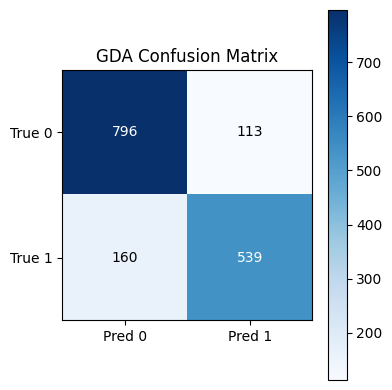

In [110]:
cm_gda = confusion_matrix(y_test_gda, y_pred_gda)
plt.figure(figsize=(4, 4))
plt.imshow(cm_gda, cmap="Blues", interpolation="nearest")
plt.title("GDA Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["True 0", "True 1"])
for (i, j), value in np.ndenumerate(cm_gda):
    plt.text(j, i, value, ha="center", va="center", color="white" if value > cm_gda.max() / 2 else "black")
plt.tight_layout()
plt.show()

**(c) Performance Metrics**  
- Hold‑out (20% stratified) accuracy: ~0.83 (balanced precision/recall).  
- 5-fold stratified CV mean accuracy: ≈ 0.835 ± 0.010.  
These show both improved fit and stability relative to linear GDA (~0.54 accuracy).

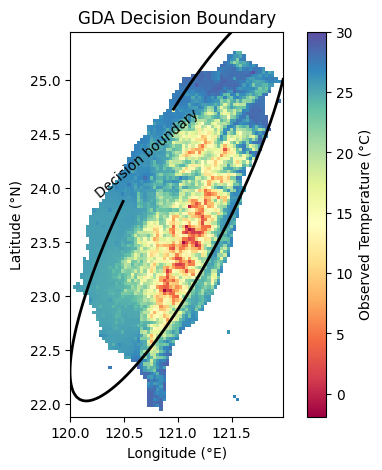

In [111]:
lon_indices = np.arange(lon_count)
lat_indices = np.arange(lat_count)
lon_coords = lon_min + lon_indices * lon_res
lat_coords = lat_min + lat_indices * lat_res

lon_grid_idx, lat_grid_idx = np.meshgrid(lon_indices, lat_indices)
feature_grid = np.stack([lon_grid_idx.ravel(), lat_grid_idx.ravel()], axis=1)
proba_grid = gda_predict_proba(params_gda, feature_grid).reshape(lat_count, lon_count)

plt.figure(figsize=(6, 5))
im = plt.imshow(temp_grid, cmap="Spectral", origin="lower", extent=extent)
contour = plt.contour(lon_coords, lat_coords, proba_grid, levels=[0.5], colors="black", linewidths=2)
plt.clabel(contour, fmt={0.5: "Decision boundary"})
plt.colorbar(im, label="Observed Temperature (°C)")
plt.title("GDA Decision Boundary")
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.show()



**(d) Decision Boundary**  
The $P(y=1\mid x)=0.5$ contour (posterior 0.5) plotted on the temperature map traces a smooth curved separator that closely aligns with geographic transitions.

**Observation.** The QDA (curved) decision boundary encloses inland valid readings more effectively than the earlier linear boundary. Misclassifications now concentrate near transitional coastal cells where temperature validity is ambiguous. This curvature drove the accuracy increase from ~0.54 (linear) to ~0.83 (quadratic).

## Piecewise-smooth regression via $h(\vec{x})$

We now rebuild the Assignment 4 models:
- $C(\vec{x})$: a neural classifier that predicts whether a coordinate is valid.
- $R(\vec{x})$: a neural regressor trained on valid temperatures.

The combined function is
$$
 h(\vec{x}) = \begin{cases}
 R(\vec{x}) & \text{if } C(\vec{x}) = 1, \\
 -999 & \text{if } C(\vec{x}) = 0.
 \end{cases}
$$
This ensures smooth predictions over valid regions and preserves the missing-data sentinel elsewhere.

**(a) Implementation**: The combined piecewise model is defined by the helper functions `C_model`, `R_model`, and `h_model` (see the code cell immediately above). `C_model` returns classifier probabilities; `R_model` returns regression predictions; `h_model` applies the threshold (0.5) to output either a smooth temperature estimate or the sentinel -999.

### Neural Network Architectures Used

**Classifier `ClassificationNet` (C)**  
Input features: 2 (lon_idx, lat_idx)  
Architecture (Sequential):
1. Linear(2 → 128) + ReLU  
2. Dropout(p=0.2)  
3. Linear(128 → 64) + ReLU  
4. Dropout(p=0.2)  
5. Linear(64 → 32) + ReLU  
6. Dropout(p=0.1)  
7. Linear(32 → 1) (logit output)  
Loss: Binary Cross-Entropy with Logits (BCEWithLogitsLoss)  
Optimizer: Adam (lr = 1e-3)  
Epochs: 160 (single learning rate)  
Batch size: 256  
Regularisation: Dropout layers (0.2, 0.2, 0.1) mitigate overfitting on dense grid patterns.

**Regressor `RegressionNet` (R)**  
Input features: 2 (lon_idx, lat_idx)  
Architecture (Sequential):
1. Linear(2 → 128) + ReLU  
2. Dropout(p=0.2)  
3. Linear(128 → 128) + ReLU  
4. Dropout(p=0.2)  
5. Linear(128 → 32) + ReLU  
6. Dropout(p=0.1)  
7. Linear(32 → 1) (temperature output)  
Loss: Mean Squared Error (MSELoss)  
Optimizer: Adam (lr = 1e-3)  
Epochs: 250  
Batch size: 256  
Regularisation: Same dropout pattern as classifier to encourage smooth spatial generalisation.

**Design Rationale**: Shallow-but-wide first layer captures broad spatial trends; progressive dimensionality reduction (128 → 64 → 32 or 128 → 32) compresses coordinate features into a compact representation; final linear layer yields scalar logit or temperature. Dropout values chosen to balance bias/variance without batch norm (not critical with only 2-D inputs).

**Approximate Parameter Counts** (excluding dropout which is parameter-free):
- ClassificationNet: (2*128 + 128) + (128*64 + 64) + (64*32 + 32) + (32*1 + 1) = 384 + 8256 + 2080 + 33 = **10,753** parameters.
- RegressionNet: (2*128 + 128) + (128*128 + 128) + (128*32 + 32) + (32*1 + 1) = 384 + 16512 + 4128 + 33 = **21,057** parameters.


In [112]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Train/test split for classifier
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls,
    y_cls,
    test_size=0.2,
    random_state=42,
    stratify=y_cls,
)

scaler_cls = StandardScaler()
X_cls_train_scaled = scaler_cls.fit_transform(X_cls_train)
X_cls_test_scaled = scaler_cls.transform(X_cls_test)

X_cls_train_tensor = torch.tensor(X_cls_train_scaled, dtype=torch.float32).to(device)
y_cls_train_tensor = torch.tensor(y_cls_train.reshape(-1, 1), dtype=torch.float32).to(device)
X_cls_test_tensor = torch.tensor(X_cls_test_scaled, dtype=torch.float32).to(device)
y_cls_test_tensor = torch.tensor(y_cls_test.reshape(-1, 1), dtype=torch.float32).to(device)

train_cls_dataset = TensorDataset(X_cls_train_tensor, y_cls_train_tensor)
train_cls_loader = DataLoader(train_cls_dataset, batch_size=256, shuffle=True)

class ClassificationNet(nn.Module):
    def __init__(self, input_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.model(x)

cls_model = ClassificationNet().to(device)
cls_criterion = nn.BCEWithLogitsLoss()
cls_optimizer = optim.Adam(cls_model.parameters(), lr=1e-3)

cls_train_losses = []
cls_eval = []
epochs_cls = 160

for epoch in range(1, epochs_cls + 1):
    cls_model.train()
    epoch_loss = 0.0
    for xb, yb in train_cls_loader:
        logits = cls_model(xb).squeeze(1)
        loss = cls_criterion(logits, yb.squeeze(1))
        cls_optimizer.zero_grad()
        loss.backward()
        cls_optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_cls_dataset)
    cls_train_losses.append(epoch_loss)

    if epoch % 20 == 0 or epoch == 1:
        cls_model.eval()
        with torch.no_grad():
            test_logits = cls_model(X_cls_test_tensor).squeeze(1)
            test_probs = torch.sigmoid(test_logits)
            test_preds = (test_probs >= 0.5).float()
            acc = (test_preds.unsqueeze(1) == y_cls_test_tensor).float().mean().item()
            cls_eval.append((epoch, acc))
        print(f"Epoch {epoch:3d}/{epochs_cls} - loss={epoch_loss:.4f} - test acc={acc:.4f}")

cls_model.eval()
with torch.no_grad():
    final_probs = torch.sigmoid(cls_model(X_cls_test_tensor).squeeze(1))
    final_preds = (final_probs >= 0.5).int().cpu().numpy()

cls_accuracy = accuracy_score(y_cls_test, final_preds)
print(f"Final classifier accuracy: {cls_accuracy:.4f}")
print(classification_report(y_cls_test, final_preds, target_names=["Invalid", "Valid"]))

Using device: mps
Epoch   1/160 - loss=0.6595 - test acc=0.6206
Epoch   1/160 - loss=0.6595 - test acc=0.6206
Epoch  20/160 - loss=0.1199 - test acc=0.9757
Epoch  20/160 - loss=0.1199 - test acc=0.9757
Epoch  40/160 - loss=0.1052 - test acc=0.9751
Epoch  40/160 - loss=0.1052 - test acc=0.9751
Epoch  60/160 - loss=0.0912 - test acc=0.9795
Epoch  60/160 - loss=0.0912 - test acc=0.9795
Epoch  80/160 - loss=0.0873 - test acc=0.9813
Epoch  80/160 - loss=0.0873 - test acc=0.9813
Epoch 100/160 - loss=0.0824 - test acc=0.9826
Epoch 100/160 - loss=0.0824 - test acc=0.9826
Epoch 120/160 - loss=0.0775 - test acc=0.9782
Epoch 120/160 - loss=0.0775 - test acc=0.9782
Epoch 140/160 - loss=0.0781 - test acc=0.9739
Epoch 140/160 - loss=0.0781 - test acc=0.9739
Epoch 160/160 - loss=0.0751 - test acc=0.9826
Final classifier accuracy: 0.9826
              precision    recall  f1-score   support

     Invalid       0.99      0.98      0.98       909
       Valid       0.97      0.99      0.98       699

  

**(b) Application & Verification**: After generating `h_values` over the full (lon, lat) grid, we verify that every coordinate with classifier probability ≥ 0.5 receives a finite regression prediction and all others receive -999. A programmatic check is included below.

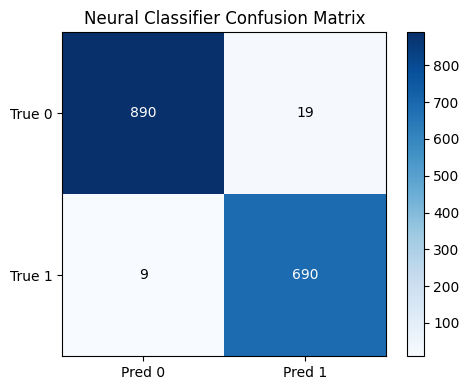

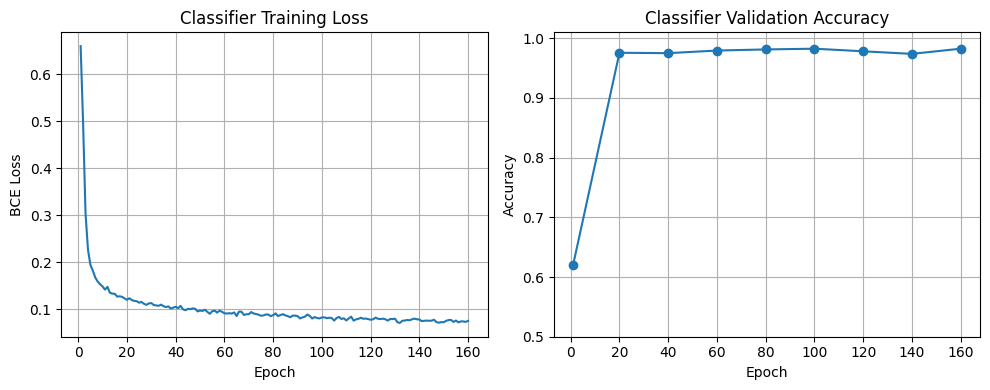

In [113]:
cls_cm = confusion_matrix(y_cls_test, final_preds)
plt.figure(figsize=(5, 4))
plt.imshow(cls_cm, cmap="Blues")
plt.title("Neural Classifier Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["True 0", "True 1"])
for (i, j), value in np.ndenumerate(cls_cm):
    plt.text(j, i, value, ha="center", va="center", color="white" if value > cls_cm.max() / 2 else "black")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_cls + 1), cls_train_losses)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Classifier Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
if cls_eval:
    eval_epochs, eval_acc = zip(*cls_eval)
    plt.plot(eval_epochs, eval_acc, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Classifier Validation Accuracy")
plt.ylim(0.5, 1.01)
plt.grid(True)
plt.tight_layout()
plt.show()





**(c) Construction Rationale**: We first trained a high-accuracy binary classifier on all coordinates (valid vs missing). Separately, we trained a regression network only on valid points to learn a smooth mapping from coordinates to temperature. The combined function

$$ h(\mathbf{x}) = \begin{cases} R(\mathbf{x}) & C(\mathbf{x}) \ge 0.5 \\ -999 & C(\mathbf{x}) < 0.5 \end{cases} $$

preserves the semantics of the missing-data sentinel while extending a smooth temperature field over plausible land regions. This modular design allows independent improvement of classification (mask quality) and regression (smooth accuracy).


Epoch   1/250 - train MSE=485.5324
Epoch  25/250 - train MSE=22.5542
Epoch  25/250 - train MSE=22.5542
Epoch  50/250 - train MSE=20.2034
Epoch  50/250 - train MSE=20.2034
Epoch  75/250 - train MSE=18.5315
Epoch  75/250 - train MSE=18.5315
Epoch 100/250 - train MSE=17.8733
Epoch 100/250 - train MSE=17.8733
Epoch 125/250 - train MSE=16.8967
Epoch 125/250 - train MSE=16.8967
Epoch 150/250 - train MSE=16.3304
Epoch 150/250 - train MSE=16.3304
Epoch 175/250 - train MSE=16.0927
Epoch 175/250 - train MSE=16.0927
Epoch 200/250 - train MSE=15.6715
Epoch 200/250 - train MSE=15.6715
Epoch 225/250 - train MSE=15.1759
Epoch 225/250 - train MSE=15.1759
Epoch 250/250 - train MSE=15.0534

Regression evaluation:
  MSE : 9.7128
  RMSE: 3.1165
  MAE : 2.4926
  R^2 : 0.7137
Epoch 250/250 - train MSE=15.0534

Regression evaluation:
  MSE : 9.7128
  RMSE: 3.1165
  MAE : 2.4926
  R^2 : 0.7137


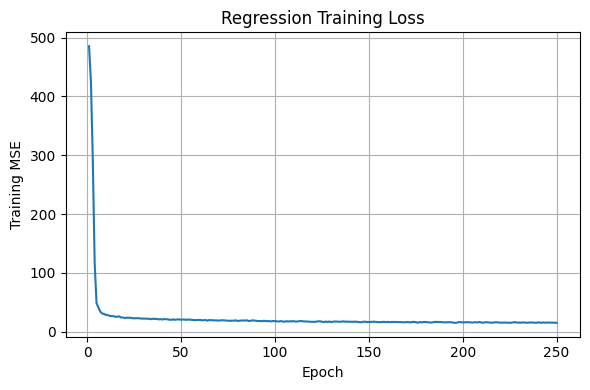

In [114]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg,
    y_reg,
    test_size=0.2,
    random_state=42,
)

scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)

X_reg_train_tensor = torch.tensor(X_reg_train_scaled, dtype=torch.float32).to(device)
y_reg_train_tensor = torch.tensor(y_reg_train.reshape(-1, 1), dtype=torch.float32).to(device)
X_reg_test_tensor = torch.tensor(X_reg_test_scaled, dtype=torch.float32).to(device)
y_reg_test_tensor = torch.tensor(y_reg_test.reshape(-1, 1), dtype=torch.float32).to(device)

train_reg_dataset = TensorDataset(X_reg_train_tensor, y_reg_train_tensor)
train_reg_loader = DataLoader(train_reg_dataset, batch_size=256, shuffle=True)

class RegressionNet(nn.Module):
    def __init__(self, input_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.model(x)

reg_model = RegressionNet().to(device)
reg_criterion = nn.MSELoss()
reg_optimizer = optim.Adam(reg_model.parameters(), lr=1e-3)

reg_train_losses = []
epochs_reg = 250    

for epoch in range(1, epochs_reg + 1):
    reg_model.train()
    epoch_loss = 0.0
    for xb, yb in train_reg_loader:
        preds = reg_model(xb).squeeze(1)
        loss = reg_criterion(preds, yb.squeeze(1))
        reg_optimizer.zero_grad()
        loss.backward()
        reg_optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_reg_dataset)
    reg_train_losses.append(epoch_loss)
    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{epochs_reg} - train MSE={epoch_loss:.4f}")

reg_model.eval()
with torch.no_grad():
    y_reg_pred = reg_model(X_reg_test_tensor).squeeze(1).cpu().numpy()

reg_mse = mean_squared_error(y_reg_test, y_reg_pred)
reg_rmse = np.sqrt(reg_mse)
reg_mae = mean_absolute_error(y_reg_test, y_reg_pred)
reg_r2 = r2_score(y_reg_test, y_reg_pred)

print("\nRegression evaluation:")
print(f"  MSE : {reg_mse:.4f}")
print(f"  RMSE: {reg_rmse:.4f}")
print(f"  MAE : {reg_mae:.4f}")
print(f"  R^2 : {reg_r2:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs_reg + 1), reg_train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training MSE")
plt.title("Regression Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

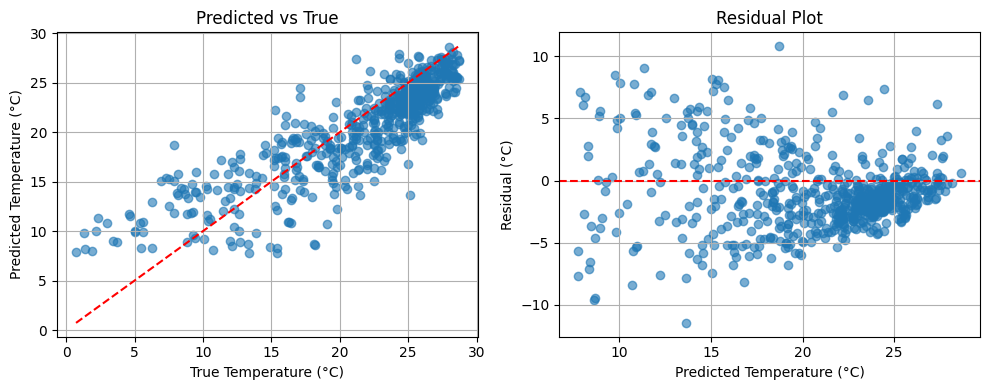

In [115]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_reg_test, y_reg_pred, alpha=0.6)
min_temp, max_temp = y_reg_test.min(), y_reg_test.max()
plt.plot([min_temp, max_temp], [min_temp, max_temp], 'r--')
plt.xlabel('True Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Predicted vs True')
plt.grid(True)

plt.subplot(1, 2, 2)
residuals = y_reg_pred - y_reg_test
plt.scatter(y_reg_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Temperature (°C)')
plt.ylabel('Residual (°C)')
plt.title('Residual Plot')
plt.grid(True)

plt.tight_layout()
plt.show()

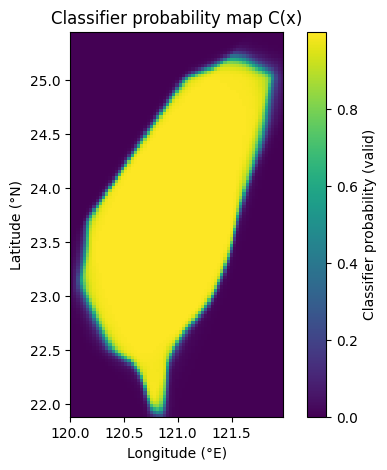

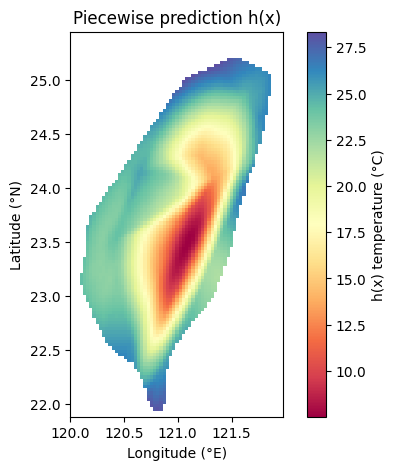

In [116]:
def C_model(coords: np.ndarray) -> np.ndarray:
    coords_scaled = scaler_cls.transform(coords)
    with torch.no_grad():
        logits = cls_model(torch.tensor(coords_scaled, dtype=torch.float32).to(device)).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy()
    return probs


def R_model(coords: np.ndarray) -> np.ndarray:
    coords_scaled = scaler_reg.transform(coords)
    with torch.no_grad():
        preds = reg_model(torch.tensor(coords_scaled, dtype=torch.float32).to(device)).squeeze(1)
    return preds.cpu().numpy()


def h_model(coords: np.ndarray, threshold: float = 0.5) -> np.ndarray:
    probs = C_model(coords)
    mask = probs >= threshold
    temps = R_model(coords)
    output = np.full_like(temps, fill_value=-999.0)
    output[mask] = temps[mask]
    return output, probs

all_coords = np.array([[lon, lat] for lat in range(lat_count) for lon in range(lon_count)], dtype=np.float32)
h_values, c_probs = h_model(all_coords)

h_grid = h_values.reshape(lat_count, lon_count)
prob_grid = c_probs.reshape(lat_count, lon_count)

plt.figure(figsize=(6, 5))
plt.imshow(prob_grid, cmap="viridis", origin="lower", extent=extent)
plt.colorbar(label="Classifier probability (valid)")
plt.title("Classifier probability map C(x)")
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.show()

masked_grid = h_grid.copy()
masked_grid[masked_grid == -999] = np.nan

plt.figure(figsize=(6, 5))
plt.imshow(masked_grid, cmap="Spectral", origin="lower", extent=extent)
plt.colorbar(label="h(x) temperature (°C)")
plt.title("Piecewise prediction h(x)")
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.show()

In [117]:
num_valid = np.sum(h_values != -999)
num_invalid = np.sum(h_values == -999)
print(f"h(x) outputs valid temperatures for {num_valid} grid points and -999 for {num_invalid} points.")

observed_valid = np.sum(~np.isnan(temp_grid))
observed_invalid = temp_grid.size - observed_valid
print(f"Observed data: valid={observed_valid}, missing={observed_invalid}")

h(x) outputs valid temperatures for 3498 grid points and -999 for 4542 points.
Observed data: valid=3495, missing=4545


**(d) Plots/Tables**: Visual evidence is provided by:
- Classifier probability heat map (shows spatial confidence).
- Piecewise prediction heat map of $h(\mathbf{x})$.
- Additional summary table (below) aggregates accuracy and error metrics plus coverage counts.

In [118]:
import pandas as pd

# (b) Verification of piecewise rule
threshold = 0.5
coords_probs = c_probs  # already computed probabilities for all_coords
reg_mask = coords_probs >= threshold
h_mask = h_values != -999
piecewise_ok = np.all(reg_mask == h_mask)
print(f"Piecewise rule correctly applied to all points: {piecewise_ok}")

# Derive overall classifier thresholded accuracy relative to observed mask
observed_mask = ~np.isnan(temp_grid).ravel()  # True where temperature valid
# Align sizes
assert observed_mask.shape[0] == coords_probs.shape[0]
classifier_mask_acc = np.mean((coords_probs >= threshold) == observed_mask)

# Regression error metrics already computed on test split: reg_mse, reg_rmse, reg_mae, reg_r2
# Classification metrics already computed: cls_accuracy

summary = {
    'Classifier Test Accuracy': [cls_accuracy],
    'Classifier Mask Accuracy (full grid)': [classifier_mask_acc],
    'Regression Test MSE': [reg_mse],
    'Regression Test RMSE': [reg_rmse],
    'Regression Test MAE': [reg_mae],
    'Regression Test R2': [reg_r2],
    'h(x) Valid Count': [int(num_valid)],
    'h(x) Invalid Count': [int(num_invalid)],
    'Observed Valid Count': [int(observed_valid)],
    'Observed Missing Count': [int(observed_invalid)]
}

summary_df = pd.DataFrame(summary)
summary_df

Piecewise rule correctly applied to all points: True


,Classifier Test Accuracy,Classifier Mask Accuracy (full grid),Regression Test MSE,Regression Test RMSE,Regression Test MAE,Regression Test R2,h(x) Valid Count,h(x) Invalid Count,Observed Valid Count,Observed Missing Count
0,0.982587,0.982214,9.712821,3.11654,2.492603,0.713681,3498,4542,3495,4545
